## USGS data description

- time: час землетрусу у форматі UTC
- latitude: широта епіцентру землетрусу
- longitude: довгота епіцентру землетрусу
- depth: глибина землетрусу у кілометрах
- mag: магнітуда землетрусу
- magType: тип магнітуди, наприклад, "mb" для магнітуди Мб, "ml" для магнітуди Мл і т.д.
- nst: кількість визначень, що використовувалися для розрахунку магнітуди
- gap: кутовий проміжок між найбільш і найменш точним визначеннями магнітуди
- dmin: найменша відстань між епіцентром землетрусу та найближчим станом (у градусах)
- rms: корінь середньоквадратичної помилки для геологічних даних, використовуваних для розрахунку магнітуди
- net: ідентифікатор мережі, що зібрала дані
- id: ідентифікатор землетрусу
- updated: час оновлення інформації про землетрус у форматі UTC
- place: місце, де відбувся землетрус
- type: тип землетрусу
- horizontalError: горизонтальна помилка (у кілометрах)
- depthError: помилка глибини (у кілометрах)
- magError: помилка магнітуди
- magNst: кількість визначень, використовуваних для розрахунку mag
- status: статус землетрусу

In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import date
import datetime
from geopy.geocoders import Nominatim
import geocoder
from googletrans import Translator
from google.cloud import storage
import os
import io
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import statsmodels.api as sm

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
today = date.today()
year = today.year
print("Today's date:", today, "Today's year:", year)

Today's date: 2023-06-13 Today's year: 2023


In [3]:
path = f'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime={year}-06-01%2000:00:00&endtime={today}%2023:59:59&minmagnitude=2.5&orderby=time'
data = pd.read_csv(path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             605 non-null    object 
 1   latitude         605 non-null    float64
 2   longitude        605 non-null    float64
 3   depth            605 non-null    float64
 4   mag              605 non-null    float64
 5   magType          605 non-null    object 
 6   nst              529 non-null    float64
 7   gap              529 non-null    float64
 8   dmin             511 non-null    float64
 9   rms              605 non-null    float64
 10  net              605 non-null    object 
 11  id               605 non-null    object 
 12  updated          605 non-null    object 
 13  place            561 non-null    object 
 14  type             605 non-null    object 
 15  horizontalError  519 non-null    float64
 16  depthError       605 non-null    float64
 17  magError        

In [5]:
data.head(5)

time  latitude  longitude   depth  mag magType   nst  \
0  2023-06-13T19:01:13.781Z  -29.1600  -177.1940  55.345  4.9      mb  41.0   
1  2023-06-13T18:35:55.463Z  -29.2453  -177.0715  52.594  5.1      mb  64.0   
2  2023-06-13T17:38:15.897Z  -29.3664  -177.0733  23.142  5.3     mww  82.0   
3  2023-06-13T17:03:21.208Z  -29.1697  -177.2486  57.260  5.2      mb  50.0   
4  2023-06-13T17:01:35.961Z  -29.4460  -176.8477  21.052  5.4     mww  62.0   

     gap   dmin   rms  ...                   updated  \
0  115.0  0.643  1.02  ...  2023-06-13T19:23:04.040Z   
1  115.0  0.742  0.96  ...  2023-06-13T18:59:50.040Z   
2   73.0  0.747  0.92  ...  2023-06-13T18:57:47.040Z   
3  126.0  0.594  1.05  ...  2023-06-13T18:38:18.040Z   
4   59.0  0.954  0.80  ...  2023-06-13T19:05:27.843Z   

                           place        type horizontalError depthError  \
0  Kermadec Islands, New Zealand  earthquake           10.77      6.325   
1  Kermadec Islands, New Zealand  earthquake           10.22      5.097   
2  Kermadec Islands, New Zealand  earthquake            9.66      4.167   
3  Kermadec Islands, New Zealand  earthquake           10.26      5.579   
4        Kermadec Islands region  earthquake            8.87      4.703   

   magError  magNst    status  locationSource magSource  
0     0.086    42.0  reviewed              us        us  
1     0.073    61.0  reviewed              us        us  
2     0.073    18.0  reviewed              us        us  
3     0.081    52.0  reviewed              us        us  
4     0.068    21.0  reviewed              us        us  

[5 rows x 22 columns]

In [6]:
round(data['mag']).value_counts()

3.0    215
4.0    204
5.0    152
2.0     22
6.0     12
Name: mag, dtype: int64

In [7]:
dataPlaceNotNaN = data.dropna(subset=['place'])
data.reset_index(drop=True) #new index


time  latitude   longitude   depth   mag magType  \
0    2023-06-13T19:01:13.781Z  -29.1600 -177.194000  55.345  4.90      mb   
1    2023-06-13T18:35:55.463Z  -29.2453 -177.071500  52.594  5.10      mb   
2    2023-06-13T17:38:15.897Z  -29.3664 -177.073300  23.142  5.30     mww   
3    2023-06-13T17:03:21.208Z  -29.1697 -177.248600  57.260  5.20      mb   
4    2023-06-13T17:01:35.961Z  -29.4460 -176.847700  21.052  5.40     mww   
..                        ...       ...         ...     ...   ...     ...   
600  2023-06-01T01:18:31.139Z   23.9567  122.551600  24.941  4.30      mb   
601  2023-06-01T00:47:01.168Z   54.1821 -162.472000  10.000  2.50      ml   
602  2023-06-01T00:44:35.730Z   36.5485   71.274900  64.982  4.20      mb   
603  2023-06-01T00:25:31.000Z   40.4675 -124.764167  23.560  2.64      md   
604  2023-06-01T00:05:17.507Z   -5.8099  151.932200  35.000  5.30      mb   

      nst    gap    dmin   rms  ...                   updated  \
0    41.0  115.0  0.6430  1.02  ...  2023-06-13T19:23:04.040Z   
1    64.0  115.0  0.7420  0.96  ...  2023-06-13T18:59:50.040Z   
2    82.0   73.0  0.7470  0.92  ...  2023-06-13T18:57:47.040Z   
3    50.0  126.0  0.5940  1.05  ...  2023-06-13T18:38:18.040Z   
4    62.0   59.0  0.9540  0.80  ...  2023-06-13T19:05:27.843Z   
..    ...    ...     ...   ...  ...                       ...   
600  24.0   74.0  0.6590  0.60  ...  2023-06-02T03:45:17.040Z   
601  14.0  219.0  0.7960  0.74  ...  2023-06-13T05:35:25.040Z   
602  31.0  136.0  2.7710  0.44  ...  2023-06-03T22:33:05.040Z   
603  45.0  234.0  0.3256  0.16  ...  2023-06-03T22:11:31.040Z   
604  62.0   65.0  5.9270  0.87  ...  2023-06-01T00:23:42.040Z   

                                      place        type horizontalError  \
0             Kermadec Islands, New Zealand  earthquake           10.77   
1             Kermadec Islands, New Zealand  earthquake           10.22   
2             Kermadec Islands, New Zealand  earthquake            9.66   
3             Kermadec Islands, New Zealand  earthquake           10.26   
4                   Kermadec Islands region  earthquake            8.87   
..                                      ...         ...             ...   
600             72 km SW of Yonakuni, Japan  earthquake            3.92   
601                        Alaska Peninsula  earthquake            3.35   
602     27 km WSW of Ashkāsham, Afghanistan  earthquake            8.80   
603                44km WNW of Petrolia, CA  earthquake            1.06   
604  166 km SSW of Kokopo, Papua New Guinea  earthquake            7.22   

    depthError  magError  magNst    status  locationSource magSource  
0        6.325     0.086    42.0  reviewed              us        us  
1        5.097     0.073    61.0  reviewed              us        us  
2        4.167     0.073    18.0  reviewed              us        us  
3        5.579     0.081    52.0  reviewed              us        us  
4        4.703     0.068    21.0  reviewed              us        us  
..         ...       ...     ...       ...             ...       ...  
600      5.958     0.161    11.0  reviewed              us        us  
601      2.005     0.148     6.0  reviewed              us        us  
602      6.393     0.131    16.0  reviewed              us        us  
603      3.570     0.250    38.0  reviewed              nc        nc  
604      1.867     0.046   161.0  reviewed              us        us  

[605 rows x 22 columns]

In [8]:
dataPlaceNotNaN.head(3)

time  latitude  longitude   depth  mag magType   nst  \
0  2023-06-13T19:01:13.781Z  -29.1600  -177.1940  55.345  4.9      mb  41.0   
1  2023-06-13T18:35:55.463Z  -29.2453  -177.0715  52.594  5.1      mb  64.0   
2  2023-06-13T17:38:15.897Z  -29.3664  -177.0733  23.142  5.3     mww  82.0   

     gap   dmin   rms  ...                   updated  \
0  115.0  0.643  1.02  ...  2023-06-13T19:23:04.040Z   
1  115.0  0.742  0.96  ...  2023-06-13T18:59:50.040Z   
2   73.0  0.747  0.92  ...  2023-06-13T18:57:47.040Z   

                           place        type horizontalError depthError  \
0  Kermadec Islands, New Zealand  earthquake           10.77      6.325   
1  Kermadec Islands, New Zealand  earthquake           10.22      5.097   
2  Kermadec Islands, New Zealand  earthquake            9.66      4.167   

   magError  magNst    status  locationSource magSource  
0     0.086    42.0  reviewed              us        us  
1     0.073    61.0  reviewed              us        us  
2     0.073    18.0  reviewed              us        us  

[3 rows x 22 columns]

In [9]:
dataPlaceNotNaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 604
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             561 non-null    object 
 1   latitude         561 non-null    float64
 2   longitude        561 non-null    float64
 3   depth            561 non-null    float64
 4   mag              561 non-null    float64
 5   magType          561 non-null    object 
 6   nst              487 non-null    float64
 7   gap              487 non-null    float64
 8   dmin             470 non-null    float64
 9   rms              561 non-null    float64
 10  net              561 non-null    object 
 11  id               561 non-null    object 
 12  updated          561 non-null    object 
 13  place            561 non-null    object 
 14  type             561 non-null    object 
 15  horizontalError  477 non-null    float64
 16  depthError       561 non-null    float64
 17  magError        

In [10]:
countries = []
for i in range(len(dataPlaceNotNaN)):
    geolocator = Nominatim(user_agent="geoapiExercises")
    latitude_get = str(dataPlaceNotNaN.iloc[i]['latitude'])
    longitude_get = str(dataPlaceNotNaN.iloc[i]['longitude'])
    location = geolocator.reverse(latitude_get+","+longitude_get)
    if(location != None):
        address = location.raw['address']
        country = address.get('country', '')
        countries.append(country)
    else:
        location = 'NaN'
        countries.append(location)
    
print('finish')

finish


In [11]:
dataPlaceNotNaN.insert(loc= len(dataPlaceNotNaN.columns), column='Country', value=countries)

In [12]:
dataPlaceNotNaN.to_csv('C:/Users/Mark/Desktop/diplomna/dataset_earthquakes5')

In [13]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/Mark/Downloads/fiery-script-386716-1bae2f2db448.json"

In [14]:
storage_client = storage.Client()
bucket_name = "earthquakes-data"
file_path = "C:/Users/Mark/Desktop/diplomna/dataset_earthquakes5"
destination_blob_name = "earthquakes-data_V1.csv"

bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(file_path)



# DATA ANALISE --------------------------------------------------------------

In [15]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/Mark/Downloads/fiery-script-386716-1bae2f2db448.json"

In [16]:
storage_client = storage.Client()
bucket_name = "earthquakes-data"
file_name = "dataset_earthquakess"
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_name)
content = blob.download_as_text()

dataset = pd.read_csv(io.StringIO(content))
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       6314 non-null   int64  
 1   time             6314 non-null   object 
 2   latitude         6314 non-null   float64
 3   longitude        6314 non-null   float64
 4   depth            6314 non-null   float64
 5   mag              6314 non-null   float64
 6   magType          6314 non-null   object 
 7   nst              5827 non-null   float64
 8   gap              5826 non-null   float64
 9   dmin             5659 non-null   float64
 10  rms              6313 non-null   float64
 11  net              6314 non-null   object 
 12  id               6314 non-null   object 
 13  updated          6314 non-null   object 
 14  place            6314 non-null   object 
 15  type             6314 non-null   object 
 16  horizontalError  5791 non-null   float64
 17  depthError    

In [17]:
#dataset = pd.read_csv('C:/Users/Mark/Desktop/diplomna/dataset_earthquakess')
#dataset.info()


In [18]:
def format_date(date_string):
    date_time = pd.to_datetime(date_string)
    formatted_date = date_time.strftime("%m/%d/%Y %H:%M:%S")
    return formatted_date

dataset['time'] = dataset['time'].apply(format_date)

In [19]:
dataset.head()

Unnamed: 0                 time   latitude  longitude       depth   mag  \
0           0  04/06/2023 14:20:29  63.047500 -150.44320  100.200000  3.60   
1           1  04/06/2023 13:28:34  -5.736200  104.07220   84.646000  4.60   
2           2  04/06/2023 10:29:38  32.844543 -100.54366    0.953735  2.90   
3           4  04/06/2023 09:33:02  39.067600  -97.58780    5.000000  3.20   
4           5  04/06/2023 09:16:56  35.791500  -96.97850    7.230000  3.24   

  magType   nst    gap      dmin  ...                             place  \
0      ml   NaN    NaN       NaN  ...                    Central Alaska   
1      mb  31.0  183.0  1.762000  ...  134 km SW of Kotabumi, Indonesia   
2      ml  30.0   89.0  0.054159  ...            7 km W of Rotan, Texas   
3   mb_lg  31.0   66.0  0.762000  ...      4 km N of Bennington, Kansas   
4      ml  81.0   31.0  0.000000  ...                          Oklahoma   

         type horizontalError depthError magError magNst    status  \
0  earthquake             NaN    0.30000      NaN    NaN  reviewed   
1  earthquake        11.52000    9.61800    0.105   27.0  reviewed   
2  earthquake         0.88901    1.06477    0.100   15.0  reviewed   
3  earthquake         2.10000    1.98100    0.043  141.0  reviewed   
4  earthquake             NaN    0.30000    0.200   37.0  reviewed   

   locationSource  magSource        Country  
0              ak         ak  United States  
1              us         us      Indonesia  
2              tx         tx  United States  
3              us         us  United States  
4              ok         ok  United States  

[5 rows x 24 columns]

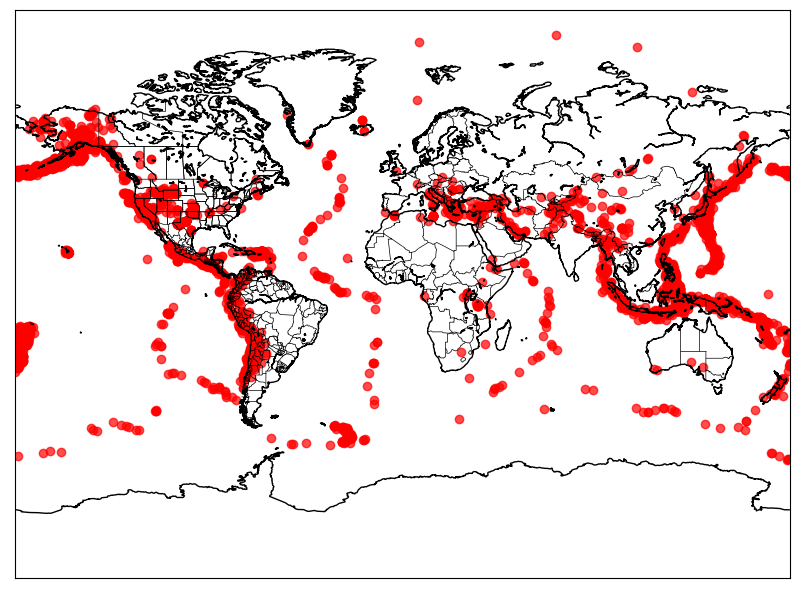

In [20]:
fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='l')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

lons = dataset['longitude']
lats = dataset['latitude']
x, y = m(lons, lats)

m.scatter(x, y, marker='o', color='red', alpha=0.7)

plt.show()


In [21]:
fig = px.scatter_mapbox(dataset,
                       lon = dataset['longitude'],
                       lat = dataset['latitude'],
                       zoom = 2,
                       color = dataset['mag'],
                       size = dataset['mag'],
                       width = 950,
                       height = 600,
                       color_continuous_scale=['#90EE90', '#bf2304'],
                       title = '')

fig.update_layout(mapbox_style = "open-street-map")
fig.update_layout(margin = {"r":0, "t":50, "l":0, "b":10})
fig.show()
fig.write_image("scatter_map.png")

In [22]:
new_time = pd.to_datetime(dataset['time'])

new_time = new_time.dt.date

fig = px.scatter_mapbox(dataset,
                       lon = dataset['longitude'],
                       lat = dataset['latitude'],
                       zoom = 1,
                       color = dataset['mag'],
                       size = dataset['mag'],
                       width = 950,
                       height = 750,
                       color_continuous_scale=['#90EE90', '#bf2304'],
                       mapbox_style='stamen-terrain',
                       animation_frame = new_time,
                       title = 'some title')

fig.update_layout(margin = {"r":0, "t":50, "l":0, "b":10})
fig.show()

<function matplotlib.pyplot.show(close=None, block=None)>

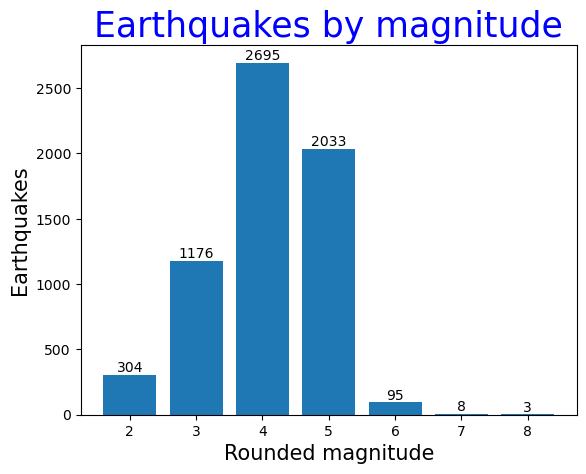

In [23]:

font_title = {'family':'Sans','color':'blue','size':25}
font_label = {'family':'Sans','color':'black','size':15}

x = pd.unique(round(dataset['mag']))
y = round(dataset['mag']).value_counts()

ax=plt.bar(x, y)

plt.title("Earthquakes by magnitude", fontdict = font_title)
plt.xlabel("Rounded magnitude", fontdict=font_label)
plt.ylabel("Earthquakes", fontdict=font_label)
plt.bar_label(ax, labels=y)

plt.show

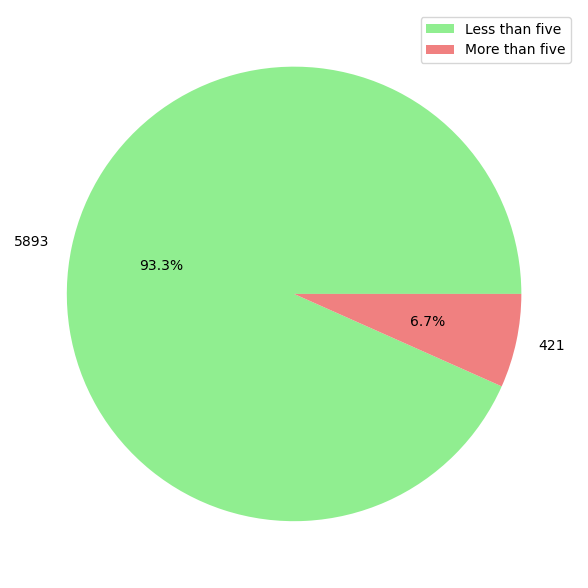

In [24]:
labels = ['Less than five', 'More than five']
colors = ['lightgreen', 'lightcoral']
fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(dataset.value_counts(dataset['mag']>=5), labels = dataset.value_counts(dataset['mag'] >= 5), autopct='%.1f%%', colors = colors)
ax.legend(labels)
plt.tight_layout()

In [25]:
mag_more5 = dataset.loc[dataset['mag'] >= 5]
mag_less5 = dataset.loc[dataset['mag'] < 5]


In [26]:
fig = px.scatter_mapbox(dataset,
                       lon = mag_less5['longitude'],
                       lat = mag_less5['latitude'],
                       zoom = 2,
                       color = mag_less5['mag'],
                       size = mag_less5['mag'],
                       width = 950,
                       height = 600,
                       color_continuous_scale=['#90EE90', '#eb922d'],
                       title = 'Magnitude less 5')

fig.update_layout(mapbox_style = "open-street-map")
fig.update_layout(margin = {"r":0, "t":50, "l":0, "b":10})
fig.show()

fig = px.scatter_mapbox(dataset,
                       lon = mag_more5['longitude'],
                       lat = mag_more5['latitude'],
                       zoom = 2,
                       color = mag_more5['mag'],
                       size = mag_more5['mag'],
                       width = 950,
                       height = 600,
                       color_continuous_scale=['#eb922d', '#bf2304'],
                       title = 'Magnitude more 5')

fig.update_layout(mapbox_style = "open-street-map")
fig.update_layout(margin = {"r":0, "t":50, "l":0, "b":10})
fig.show()

Text(0.5, 1.0, 'Dependence of Depth on Magnitude')

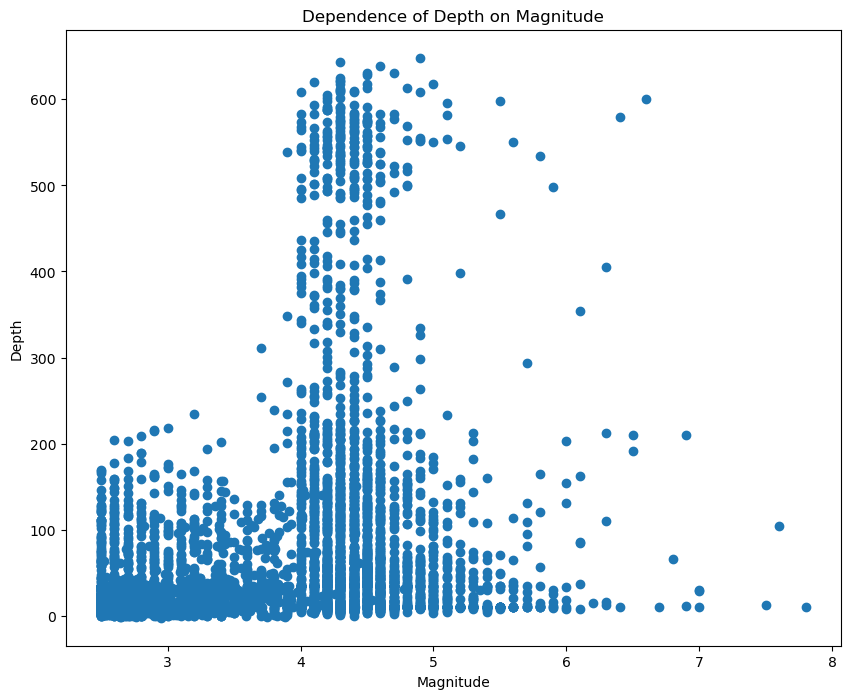

In [27]:
plt.figure(figsize=(10, 8))
plt.scatter(dataset['mag'], dataset['depth'])
plt.xlabel('Magnitude')
plt.ylabel('Depth')
plt.title('Dependence of Depth on Magnitude')

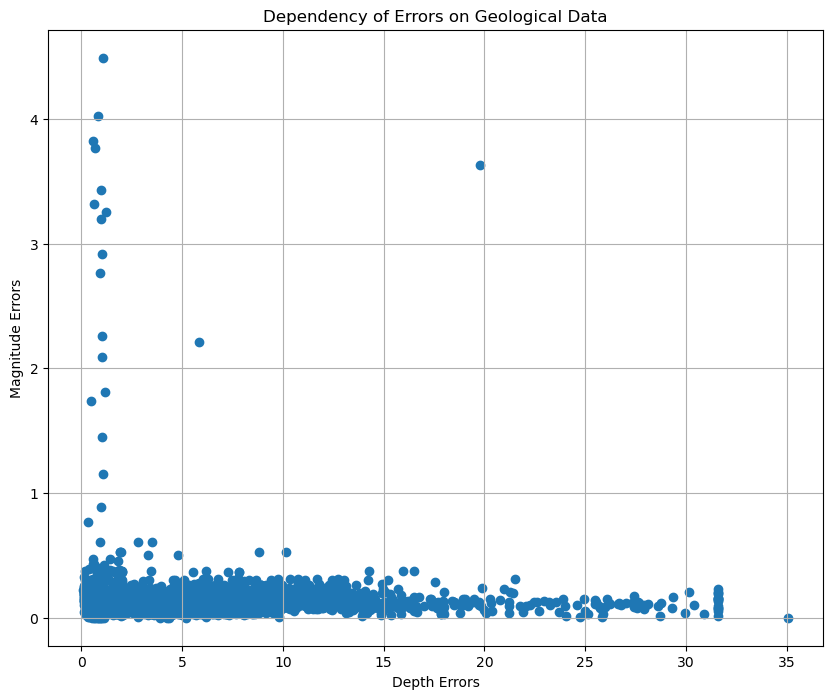

In [28]:
plt.figure(figsize=(10, 8))
plt.scatter(dataset['depthError'], dataset['magError'])
plt.xlabel('Depth Errors')
plt.ylabel('Magnitude Errors')
plt.title('Dependency of Errors on Geological Data')
plt.grid(True)
plt.show()


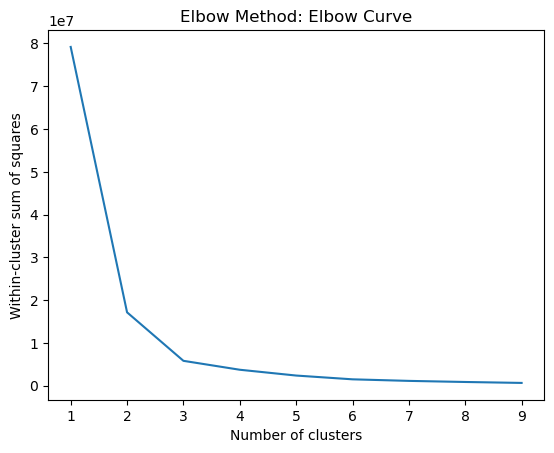

In [29]:
data = np.column_stack((dataset['mag'], dataset['depth']))  
inertia = []

for k in range(1, 10):  
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method: Elbow Curve')
plt.show()

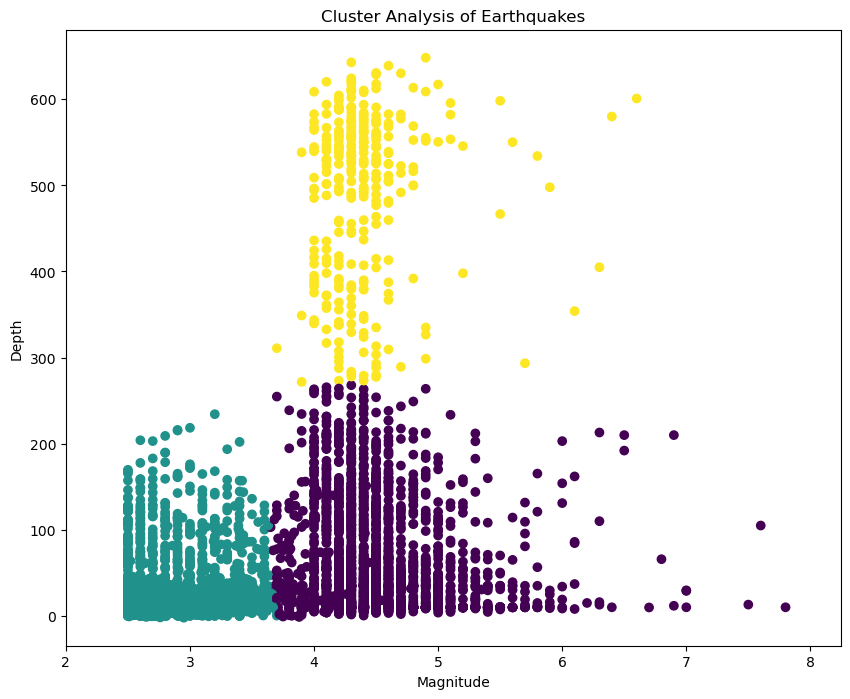

In [30]:
data = np.column_stack((dataset['mag'], dataset['depth']))
normalized_data = (data - data.mean(axis=0)) / data.std(axis=0)

k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(normalized_data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
plt.xlabel('Magnitude')
plt.ylabel('Depth')
plt.title('Cluster Analysis of Earthquakes')
plt.xlim(2)
plt.show()

Коефіцієнт кореляції магнітуди та глибини: 0.1934821246719305


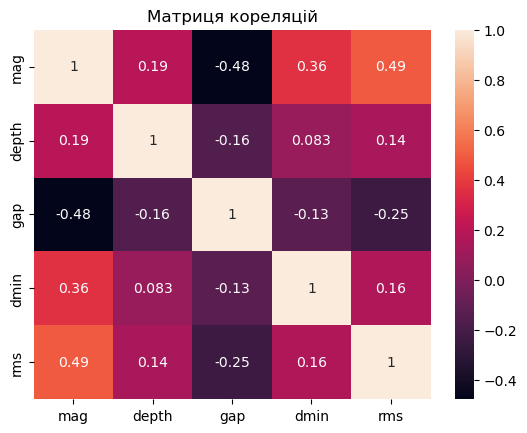

In [31]:

correlation = dataset['mag'].corr(dataset['depth'])
print(f"Коефіцієнт кореляції магнітуди та глибини: {correlation}")

correlation_matrix = dataset[['mag', 'depth', 'gap', 'dmin', 'rms']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Матриця кореляцій')
plt.show()

In [32]:
top5_country = dataset.value_counts(dataset['Country']).head(5)
top5_country = top5_country.to_frame().reset_index()
top5_country = top5_country.rename(columns= {0: 'Number'})
print(top5_country.head())


         Country  Number
0  United States    1755
1      Indonesia     560
2        Türkiye     477
3        Vanuatu     115
4          Chile     105


In [33]:
col_list = list(top5_country["Country"])
print(col_list)

['United States', 'Indonesia', 'Türkiye', 'Vanuatu', 'Chile']


In [34]:
mask = dataset['Country'].isin(col_list)
dataset = dataset.drop(index=dataset[~mask].index)

In [35]:
dataset.head()

Unnamed: 0                 time   latitude  longitude       depth   mag  \
0           0  04/06/2023 14:20:29  63.047500 -150.44320  100.200000  3.60   
1           1  04/06/2023 13:28:34  -5.736200  104.07220   84.646000  4.60   
2           2  04/06/2023 10:29:38  32.844543 -100.54366    0.953735  2.90   
3           4  04/06/2023 09:33:02  39.067600  -97.58780    5.000000  3.20   
4           5  04/06/2023 09:16:56  35.791500  -96.97850    7.230000  3.24   

  magType   nst    gap      dmin  ...                             place  \
0      ml   NaN    NaN       NaN  ...                    Central Alaska   
1      mb  31.0  183.0  1.762000  ...  134 km SW of Kotabumi, Indonesia   
2      ml  30.0   89.0  0.054159  ...            7 km W of Rotan, Texas   
3   mb_lg  31.0   66.0  0.762000  ...      4 km N of Bennington, Kansas   
4      ml  81.0   31.0  0.000000  ...                          Oklahoma   

         type horizontalError depthError magError magNst    status  \
0  earthquake             NaN    0.30000      NaN    NaN  reviewed   
1  earthquake        11.52000    9.61800    0.105   27.0  reviewed   
2  earthquake         0.88901    1.06477    0.100   15.0  reviewed   
3  earthquake         2.10000    1.98100    0.043  141.0  reviewed   
4  earthquake             NaN    0.30000    0.200   37.0  reviewed   

   locationSource  magSource        Country  
0              ak         ak  United States  
1              us         us      Indonesia  
2              tx         tx  United States  
3              us         us  United States  
4              ok         ok  United States  

[5 rows x 24 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

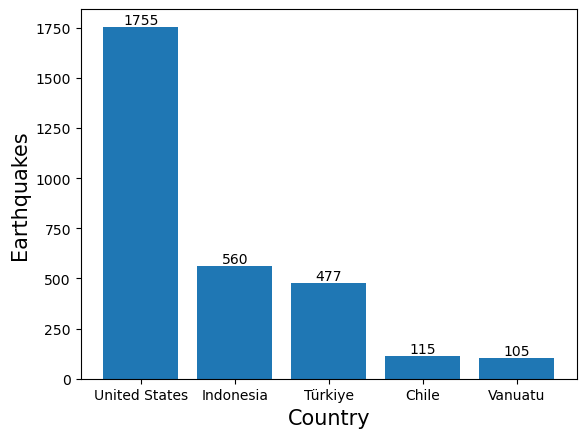

In [36]:
font_title = {'family':'Sans','color':'blue','size':25}
font_label = {'family':'Sans','color':'black','size':15}

x = dataset['Country'].unique()
y = dataset.value_counts(dataset['Country'])

ax=plt.bar(x, y)


plt.ylabel("Earthquakes", fontdict=font_label)
plt.xlabel("Country", fontdict=font_label)
plt.bar_label(ax, labels=y)

plt.show

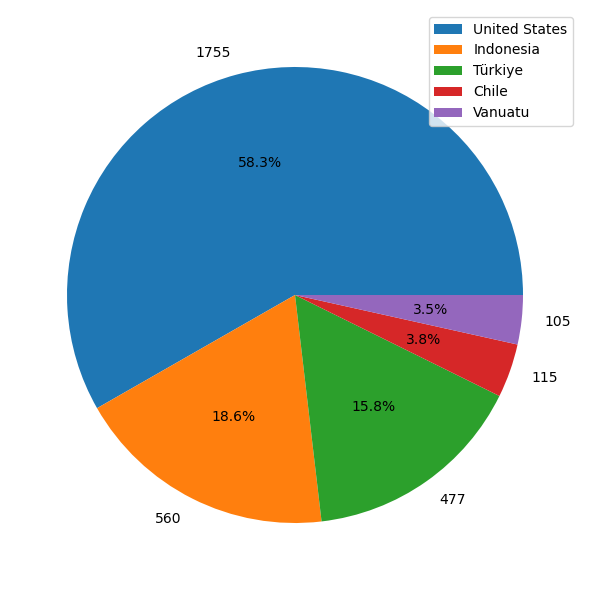

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(dataset.value_counts(dataset['Country']), labels = dataset.value_counts(dataset['Country']), autopct='%.1f%%')
ax.legend(dataset['Country'].unique())
ax.set_title('')
plt.tight_layout()

In [38]:
Chile = dataset.loc[dataset['Country'] == 'Chile']

Tur = dataset.loc[dataset['Country'] == 'Türkiye']

Vanuatu = dataset.loc[dataset['Country'] == 'Vanuatu']

Indonesia = dataset.loc[dataset['Country'] == 'Indonesia']

US = dataset.loc[dataset['Country'] == 'United States']


In [39]:
X = Tur['depth']
y = Tur['mag']

# Додавання стовпця з константою
X = sm.add_constant(X)

# Побудова регресійної моделі
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mag   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3642
Date:                Tue, 13 Jun 2023   Prob (F-statistic):              0.546
Time:                        22:43:19   Log-Likelihood:                -274.49
No. Observations:                 477   AIC:                             553.0
Df Residuals:                     475   BIC:                             561.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4046      0.063     69.917      0.0

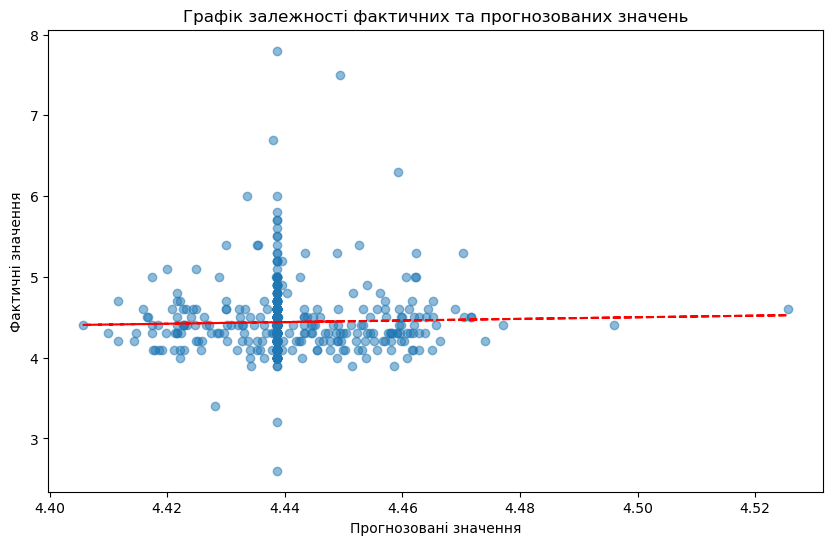

In [40]:
actual_values = Tur['mag']

# прогнозовані значення магнітуди
predicted_values = results.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, actual_values, alpha=0.5)
plt.plot(predicted_values, predicted_values, color='red', linestyle='--')
plt.xlabel('Прогнозовані значення')
plt.ylabel('Фактичні значення')
plt.title('Графік залежності фактичних та прогнозованих значень')
plt.show()



In [41]:
US = US.loc[US['mag'] >=4]
Indonesia = Indonesia.loc[Indonesia['mag'] >=4]
Vanuatu = Vanuatu.loc[Vanuatu['mag'] >=4]
Tur = Tur.loc[Tur['mag'] >=4]
Chile = Chile.loc[Chile['mag'] >=4]

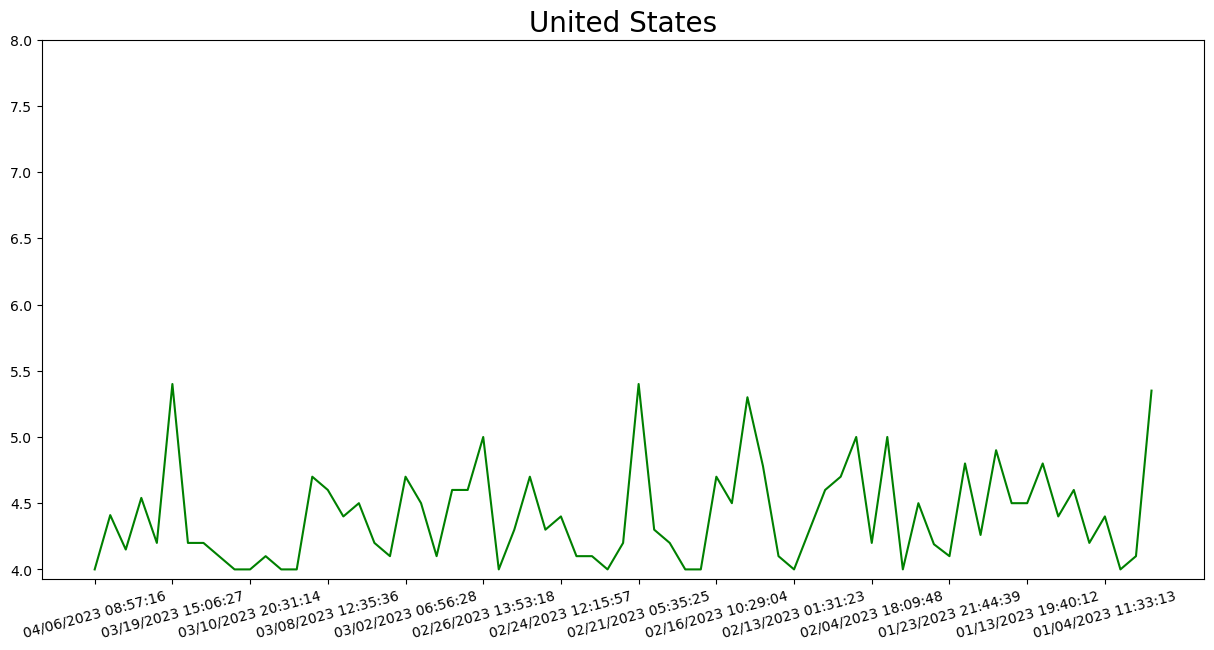

In [42]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(US['time'], US['mag'], color = 'green', label="US")

plt.xticks(rotation=15)  

interval =5 
x_ticks = range(0, len(US['time']), interval)  
x_labels = US['time'].iloc[x_ticks]  
plt.xticks(x_ticks, x_labels)  
plt.ylim(top=8)
plt.title('United States', fontsize = 20)
plt.show()

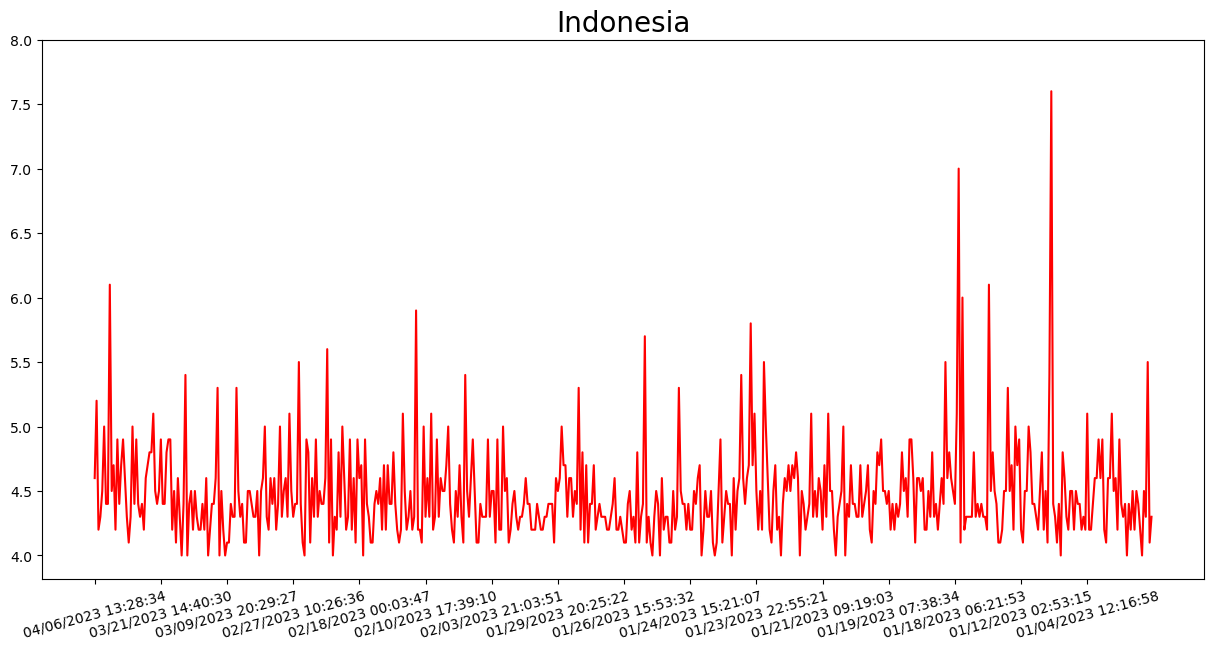

In [43]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(Indonesia['time'], Indonesia['mag'], color = 'red', label="Chile")
plt.xticks(rotation=15)  

interval =35  
x_ticks = range(0, len(Indonesia['time']), interval)  
x_labels = Indonesia['time'].iloc[x_ticks]  
plt.xticks(x_ticks, x_labels)  
plt.ylim(top=8)
plt.title('Indonesia', fontsize = 20)
plt.show()


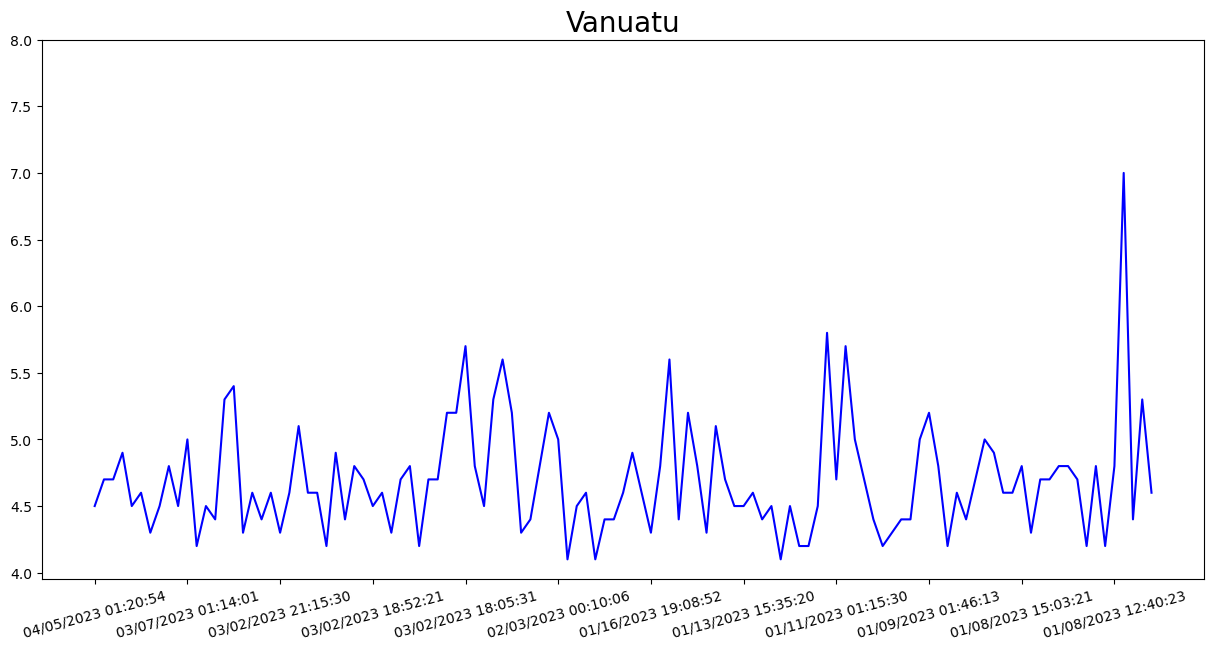

In [44]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(Vanuatu['time'], Vanuatu['mag'], color = 'blue', label="US")

plt.xticks(rotation=15)  

interval =10 
x_ticks = range(0, len(Vanuatu['time']), interval)  
x_labels = Vanuatu['time'].iloc[x_ticks]  
plt.xticks(x_ticks, x_labels)  
plt.ylim(top=8)
plt.title('Vanuatu', fontsize = 20)
plt.show()

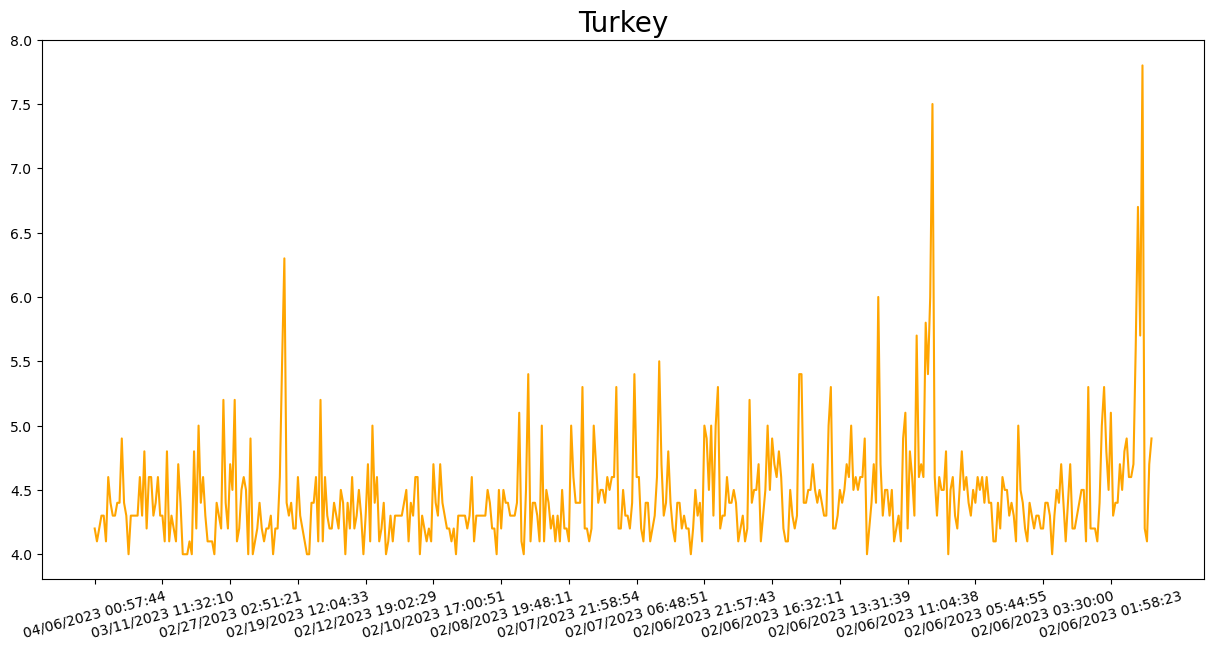

In [45]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(Tur['time'], Tur['mag'], color = 'orange', label="US")

plt.xticks(rotation=15)  

interval =30  
x_ticks = range(0, len(Tur['time']), interval)  
x_labels = Tur['time'].iloc[x_ticks]  
plt.xticks(x_ticks, x_labels)  
plt.ylim(top=8)
plt.title('Turkey', fontsize = 20)
plt.show()

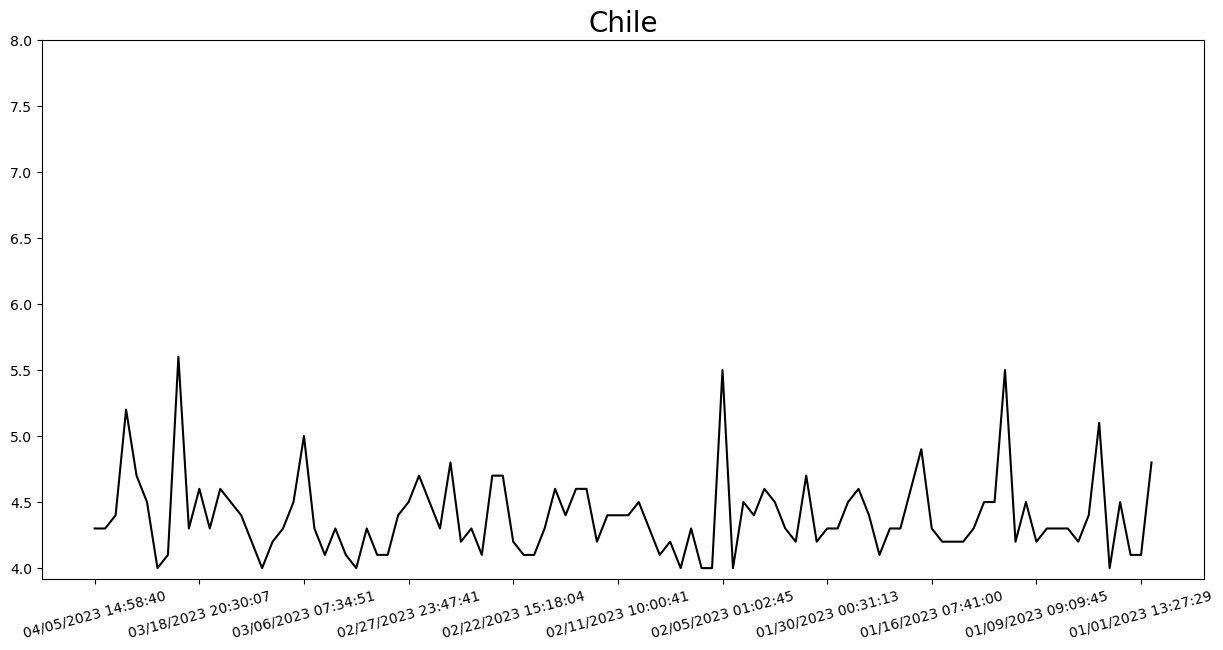

In [46]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(Chile['time'], Chile['mag'], color = 'black', label="US")

plt.xticks(rotation=15)  

interval =10  
x_ticks = range(0, len(Chile['time']), interval)  
x_labels = Chile['time'].iloc[x_ticks]  
plt.xticks(x_ticks, x_labels)  
plt.ylim(top=8)
plt.title('Chile', fontsize = 20)
plt.show()

In [47]:
meanUS = round(US['nst'].mean())
meanTur = round(Tur['nst'].mean())
meanChile = round(Chile['nst'].mean())
meanVanuatu = round(Vanuatu['nst'].mean())
meanIndonesia = round(Indonesia['nst'].mean())

print('US:', meanUS, '\n' 'Tur:', meanTur,'\n' 'Chile:', meanChile,'\n' 'Vanuatu:', meanVanuatu,'\n' 'Indonesia:', meanIndonesia)

US: 61 
Tur: 60 
Chile: 43 
Vanuatu: 43 
Indonesia: 42


In [48]:
tectonic_plates_map = pd.read_csv('C:/Users/Mark/Downloads/all.csv')
tectonic_plates_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12321 entries, 0 to 12320
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   plate   12321 non-null  object 
 1   lat     12321 non-null  float64
 2   lon     12321 non-null  float64
dtypes: float64(2), object(1)
memory usage: 288.9+ KB


In [49]:
fig_tectonic_plates_map = px.scatter_mapbox(tectonic_plates_map,
                       lon = tectonic_plates_map['lon'],
                       lat = tectonic_plates_map['lat'],
                       zoom = 2,
                       color = tectonic_plates_map['plate'],
                       width = 950,
                       height = 600,
                       title = 'tectonic plates map')


fig_tectonic_plates_map.update_layout(mapbox_style = "stamen-terrain")
fig_tectonic_plates_map.update_layout(margin = {"r":0, "t":50, "l":0, "b":10})
fig_tectonic_plates_map.show()

In [50]:

combine = dataset.loc[:, ['type','latitude','longitude']]
combine

combine.rename(columns = {'type':'plate', 'latitude':'lat',
                              'longitude':'lon'}, inplace = True)

combine=combine.assign(plate='earthquake')


In [51]:
frames = [combine, tectonic_plates_map]
  
result = pd.concat(frames)

In [52]:
result

plate        lat        lon
0      earthquake  63.047500 -150.44320
1      earthquake  -5.736200  104.07220
2      earthquake  32.844543 -100.54366
3      earthquake  39.067600  -97.58780
4      earthquake  35.791500  -96.97850
...           ...        ...        ...
12316          yz  19.713000  113.27400
12317          yz  19.288000  113.51700
12318          yz  18.863000  113.75900
12319          yz  18.438000  114.00000
12320          yz  18.438000  114.00000

[15333 rows x 3 columns]

In [53]:
fig_tectonic_plates_map = px.scatter_mapbox(result,
                       lon = result['lon'],
                       lat = result['lat'],
                       zoom = 2,
                       color = result['plate'],
                       width = 950,
                       height = 600,
                       title = 'magnitude less 5')


fig_tectonic_plates_map.update_layout(mapbox_style = "stamen-terrain")
fig_tectonic_plates_map.update_layout(margin = {"r":0, "t":50, "l":0, "b":10})
fig_tectonic_plates_map.show()

In [54]:
tect=tectonic_plates_map.assign(plate='plate')

frames2tp = [combine, tect]
  
tp_map = pd.concat(frames2tp)

In [55]:
fig_tectonic_plates_map = px.scatter_mapbox(tp_map,
                       lon = tp_map['lon'],
                       lat = tp_map['lat'],
                       zoom = 2,
                       color = tp_map['plate'],
                       width = 950,
                       height = 600,
                       title = '')


fig_tectonic_plates_map.update_layout(mapbox_style = "stamen-terrain")
fig_tectonic_plates_map.update_layout(margin = {"r":0, "t":50, "l":0, "b":10})
fig_tectonic_plates_map.show()